### loading libraries..

In [1]:
import os
import sys
import shutil
import copy
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import nltk
from nltk.corpus import words
from nltk.corpus import reuters
import corpushash as ch

disabling logging information so that we are not swamped by it when hashing several corpora in a row:

In [26]:
import logging

logging.getLogger('corpushash.hashers').setLevel(logging.WARNING)

In [27]:
corpus_path = 'bench_test'

In [28]:
plt.rcParams['figure.figsize'] = (30, 12)

## benchmark corpus

benchmark corpus is a wordlist, so that it represents a worst-case scenario where all tokens have to be hashed instead of some them being repeated and being looked-up.

### is hashing really slower than looking up words in dictionary?

we'll test the wordlist against the abc corpus, which is 3 times bigger, but which has only 31885 unique words.

In [9]:
# if corpus is missing, comment here and nltk import (above)
nltk.download('words')
nltk.download('abc')
nltk.download('reuters')

[nltk_data] Downloading package words to /home/guest/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package abc to /home/guest/nltk_data...
[nltk_data]   Package abc is already up-to-date!
[nltk_data] Downloading package reuters to /home/guest/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [10]:
print('|wordlist corpus|\ntotal nr of tokens & nr of unique tokens:', len(words.words()))

|wordlist corpus|
total nr of tokens & nr of unique tokens: 236736


In [11]:
print('|abc corpus|\ntotal nr of tokens:', len(nltk.corpus.abc.words()), '\nunique tokens:', len(set(nltk.corpus.abc.words())))

|abc corpus|
total nr of tokens: 766811 
unique tokens: 31885


##### wordlist corpus

In [28]:
corpus = [words.words()]

In [29]:
%time wordlistcorpus = ch.CorpusHash(corpus, corpus_path)

CPU times: user 5.08 s, sys: 142 ms, total: 5.22 s
Wall time: 5.22 s


In [30]:
print('decode dictionary size (bytes)\n', os.path.getsize(os.path.join(corpus_path, 'private', 'decode_dictionary.json')))

decode dictionary size (bytes)
 32944292


In [31]:
print('hashed corpus size (bytes)\n', os.path.getsize(os.path.join(wordlistcorpus.public_path, '{}.json'.format(wordlistcorpus.corpus_size-1))))

hashed corpus size (bytes)
 11363330


removing folder to have clean slate for next corpus hash:

In [32]:
shutil.rmtree(corpus_path)

##### abc corpus

In [27]:
corpus = [list(nltk.corpus.abc.words())]
len(corpus[0])

766811

In [24]:
%time abccorpus = ch.CorpusHash(corpus, corpus_path)

CPU times: user 2.01 s, sys: 45 ms, total: 2.05 s
Wall time: 2.05 s


In [25]:
print('decode dictionary size (bytes)\n', os.path.getsize(os.path.join(corpus_path, 'private', 'decode_dictionary.json')))

decode dictionary size (bytes)
 4061269


In [26]:
print('hashed corpus size (bytes)\n', os.path.getsize(os.path.join(abccorpus.public_path, '{}.json'.format(wordlistcorpus.corpus_size-1))))

hashed corpus size (bytes)
 36806930


In [16]:
shutil.rmtree(corpus_path)

## determining library complexity: three main variables

two main variables should determine the time taken to hash a corpus: 

* the documents' sizes;

* and the documents' nesting level

    a corpus of zero-depth is a list of tokens, while a higher-depth corpus is a nested list of tokens, where the nesting represents document structure, such as sentences and paragraphs.

### zero-depth corpus, one document, variable nr of tokens

In [17]:
corpus_size = 10
step = 100
iterations = 2330
max_corpus_size = corpus_size + step*iterations
loops = 1
iterations_time = np.zeros((iterations))

In [18]:
iterations_time.shape

(2330,)

In [19]:
max_corpus_size

233010

In [33]:
%%time
i = 0
for size in range(corpus_size, max_corpus_size, step):
    corpus = [words.words()[:size]]
    startt = timer()
    ch.CorpusHash(corpus, corpus_path)
    endt = timer()
    iterations_time[i] = endt - startt
    shutil.rmtree(corpus_path)
    i += 1
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


KeyboardInterrupt: 

In [ ]:
file_name = '0_d_tokens.npy'
if os.path.isfile(file_name):
    iterations_time = np.load(file_name)
else:
    np.save(file_name, iterations_time)

iterations_time is a vector with each element being the time it took to hash the corpus of a given size.

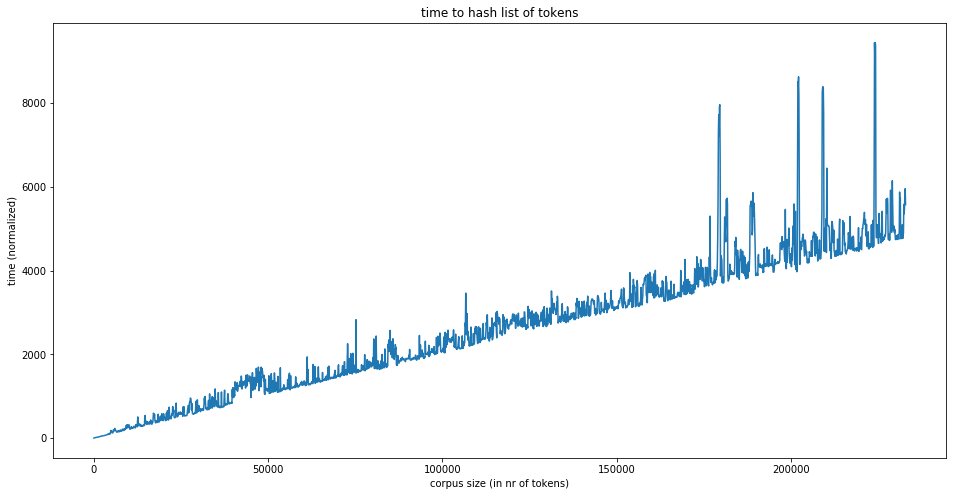

In [59]:
x = np.arange(corpus_size, max_corpus_size, step)
y = iterations_time / iterations_time[0]
plt.plot(x, y)
plt.ylabel('time (normalized)')
plt.xlabel('corpus size (in nr of tokens)')
plt.title('time to hash list of tokens')
plt.show()

In [60]:
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
print(p)

 
0.0223 x + 22.14


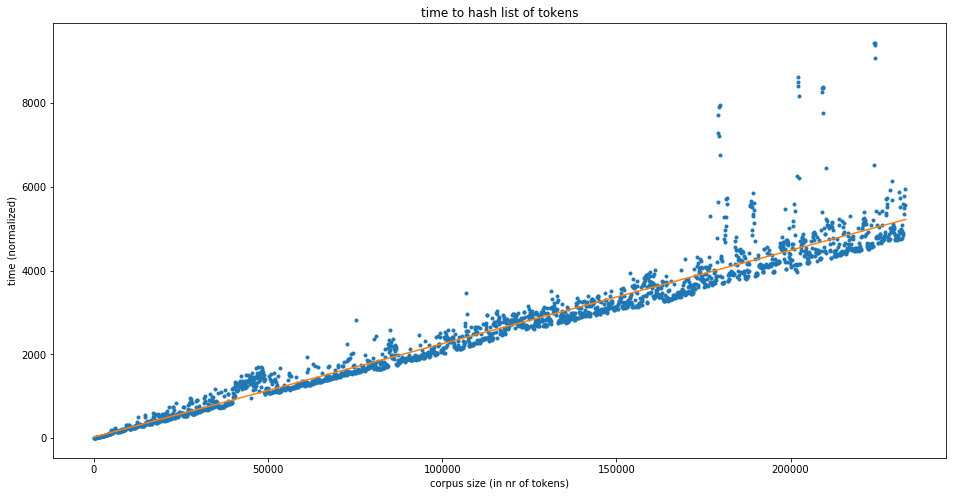

In [61]:
xp = np.linspace(corpus_size, max_corpus_size, 10000)  # creating evenly-spaced points to evaluate polynomial
plt.plot(x, y, '.', xp, p(xp), '-')
plt.ylabel('time (normalized)')
plt.xlabel('corpus size (in nr of tokens)')
plt.title('time to hash list of tokens')
plt.show()

## final benchmark

### variable nr of documents, variable corpus size, three nesting levels

### nesting level 0 (list of tokens)

using reuters corpus and varying corpus size and nr of docs independently:

In [63]:
corpus_size = 10
step = 5
iterations = 260
max_corpus_size = corpus_size + step*iterations
iterations_time = np.zeros((iterations*iterations))

In [64]:
iterations_time.shape

(100,)

In [65]:
max_corpus_size

60

In [66]:
document = list(nltk.corpus.reuters.words())

In [67]:
corpus_length = len(document)
corpus_length

1720901

In [68]:
%%time
i = 0
k = 0
for size in range(corpus_size, max_corpus_size, step):
    for nrdocs in range(iterations):
        doc_length = size
        corpus = []
        for doc in range(nrdocs+1):
            begin = doc*doc_length
            end = (1 + doc)*doc_length
            corpus.append(document[begin:end])
        startt = timer()
        a = ch.CorpusHash(corpus, corpus_path)
        endt = timer()
        iterations_time[i] = endt - startt
        shutil.rmtree(corpus_path)
        i += 1
    print(k)
    k += 1

0
1
2
3
4
5
6
7
8
9
CPU times: user 377 ms, sys: 66 ms, total: 443 ms
Wall time: 449 ms


In [ ]:
file_name = '0_d_tokens_documents.npy'
if os.path.isfile(file_name):
    iterations_time = np.load(file_name)
else:
    np.save(file_name, iterations_time)

##### plotting

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

In [13]:
xs = np.array(list(range(iterations))*iterations)  # nr of docs

In [14]:
y = []
for i in range(corpus_size, max_corpus_size, step):
    y += [i]*iterations
ys = np.array(y) # nr of tokens in each document

In [39]:
iterations_time[0]

array([ 0.00087914,  0.00064602,  0.00065183,  0.00055368,  0.00053477,
        0.00057429,  0.00053807,  0.00053106,  0.00056028,  0.00064082])

In [42]:
z = np.average(iterations_time, axis=0)
zs = z / z[0]

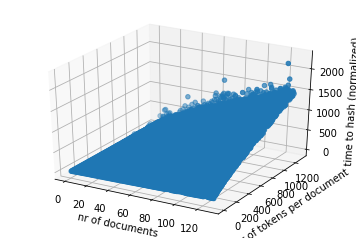

In [51]:
ax.scatter(xs, ys, zs)

ax.set_xlabel('nr of documents')
ax.set_ylabel('nr of tokens per document')
ax.set_zlabel('time to hash (normalized)')

plt.show()

### nesting level 1

using reuters and varying corpus size and nr of docs independently

In [32]:
corpus_size = 10
step = 5
iterations = 260
max_corpus_size = corpus_size + step*iterations
iterations_time = np.zeros((iterations*iterations))

In [33]:
iterations_time.shape

(67600,)

In [34]:
max_corpus_size

1310

#### using a worst-case scenario where every other word is in a nested list and the others are not

normal nesting:

In [38]:
normal_corpus = ch.text_split(reuters.raw())

In [41]:
%time ch.CorpusHash([normal_corpus], 'split_test')

CPU times: user 5.23 s, sys: 70 ms, total: 5.3 s
Wall time: 5.31 s


In [42]:
document = []
for ix, word in enumerate(reuters.words()):
    if ix % 2:
        document.append([word])
    else:
        document.append(word)
document[:10]

['ASIAN',
 ['EXPORTERS'],
 'FEAR',
 ['DAMAGE'],
 'FROM',
 ['U'],
 '.',
 ['S'],
 '.-',
 ['JAPAN']]

In [43]:
shutil.rmtree('split_test')

In [44]:
%time ch.CorpusHash([document], 'split_test')

CPU times: user 8.16 s, sys: 113 ms, total: 8.28 s
Wall time: 8.29 s


In [45]:
corpus_length = len(document)
corpus_length

1720901

In [47]:
%%time
i = 0
k = 0
for size in range(corpus_size, max_corpus_size, step):
    for nrdocs in range(iterations):
        doc_length = size
        corpus = []
        for doc in range(nrdocs+1):
            begin = doc*doc_length
            end = (1 + doc)*doc_length
            corpus.append(document[begin:end])
        startt = timer()
        a = ch.CorpusHash(corpus, corpus_path)
        endt = timer()
        iterations_time[i] = endt - startt
        shutil.rmtree(corpus_path)
        i += 1
    print(k)
    k += 1

0
1
2
3


KeyboardInterrupt: 

In [ ]:
file_name = '1_d_tokens_documents.npy'
if os.path.isfile(file_name):
    iterations_time = np.load(file_name)
else:
    np.save(file_name, iterations_time)

##### plotting

In [23]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

In [24]:
xs = np.array(list(range(iterations))*iterations)  # nr of docs

In [25]:
y = []
for i in range(corpus_size, max_corpus_size, step):
    y += [i]*iterations
ys = np.array(y) # nr of tokens in each document

In [44]:
iterations_time[0]

0.001133066019974649

In [27]:
zs = iterations_time / iterations_time[0]

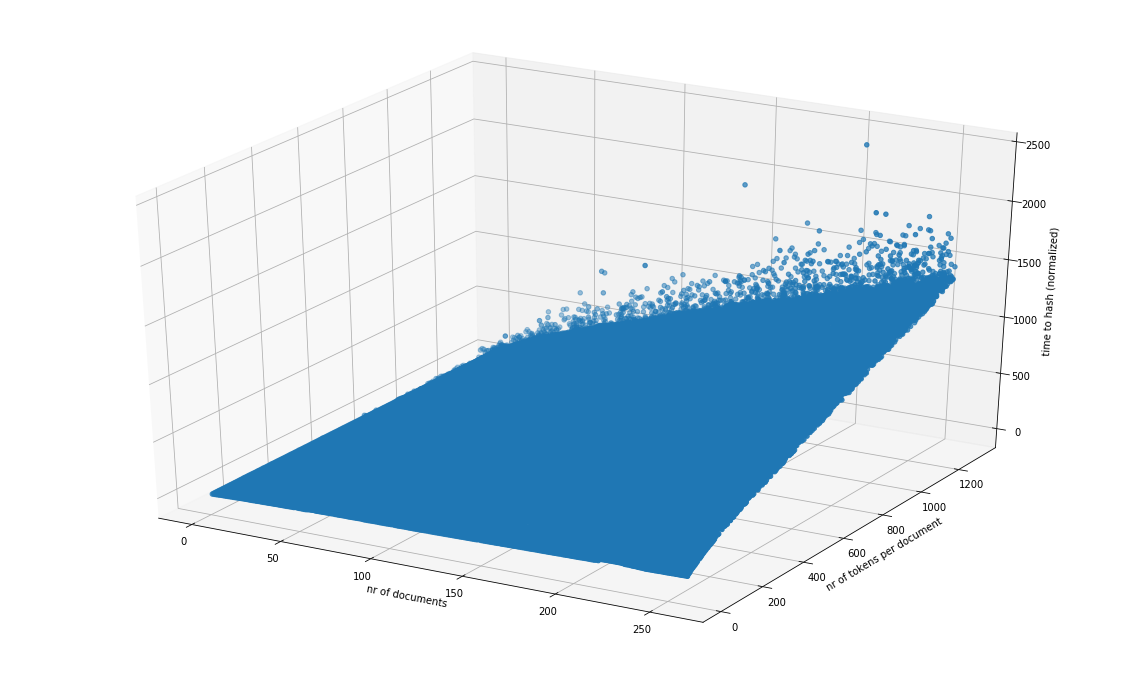

In [28]:
ax.scatter(xs, ys, zs)

ax.set_xlabel('nr of documents')
ax.set_ylabel('nr of tokens per document')
ax.set_zlabel('time to hash (normalized)')

plt.show()

### nesting level 2

In [48]:
corpus_size = 10
step = 5
iterations = 260
max_corpus_size = corpus_size + step*iterations
iterations_time = np.zeros((iterations*iterations))

In [49]:
iterations_time.shape

(67600,)

In [50]:
max_corpus_size

1310

In [51]:
document = []
for ix, word in enumerate(nltk.corpus.reuters.words()):
    if ix % 3 == 0:
        document.append(word)
    elif ix % 3 == 2:
        document.append([word])
    else:
        document.append([[word]])
document[:10]

['ASIAN',
 [['EXPORTERS']],
 ['FEAR'],
 'DAMAGE',
 [['FROM']],
 ['U'],
 '.',
 [['S']],
 ['.-'],
 'JAPAN']

In [52]:
corpus_length = len(document)
corpus_length

1720901

In [54]:
%%time
i = 0
k = 0
for size in range(corpus_size, max_corpus_size, step):
    for nrdocs in range(iterations):
        doc_length = size
        corpus = []
        for doc in range(nrdocs+1):
            begin = doc*doc_length
            end = (1 + doc)*doc_length
            corpus.append(document[begin:end])
        startt = timer()
        a = ch.CorpusHash(corpus, corpus_path)
        endt = timer()
        iterations_time[i] = endt - startt
        shutil.rmtree(corpus_path)
        i += 1
    print(k)
    k += 1
file_name = '2_d_tokens_documents.npy'
if os.path.isfile(file_name):
    iterations_time = np.load(file_name)
else:
    np.save(file_name, iterations_time)

0
1
2
3
4


KeyboardInterrupt: 

##### plotting

In [33]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

In [34]:
xs = np.array(list(range(iterations))*iterations)  # nr of docs

In [35]:
y = []
for i in range(corpus_size, max_corpus_size, step):
    y += [i]*iterations
ys = np.array(y) # nr of tokens in each document

In [40]:
iterations_time[0]

0.0019400700111873448

In [37]:
zs = iterations_time / iterations_time[0]

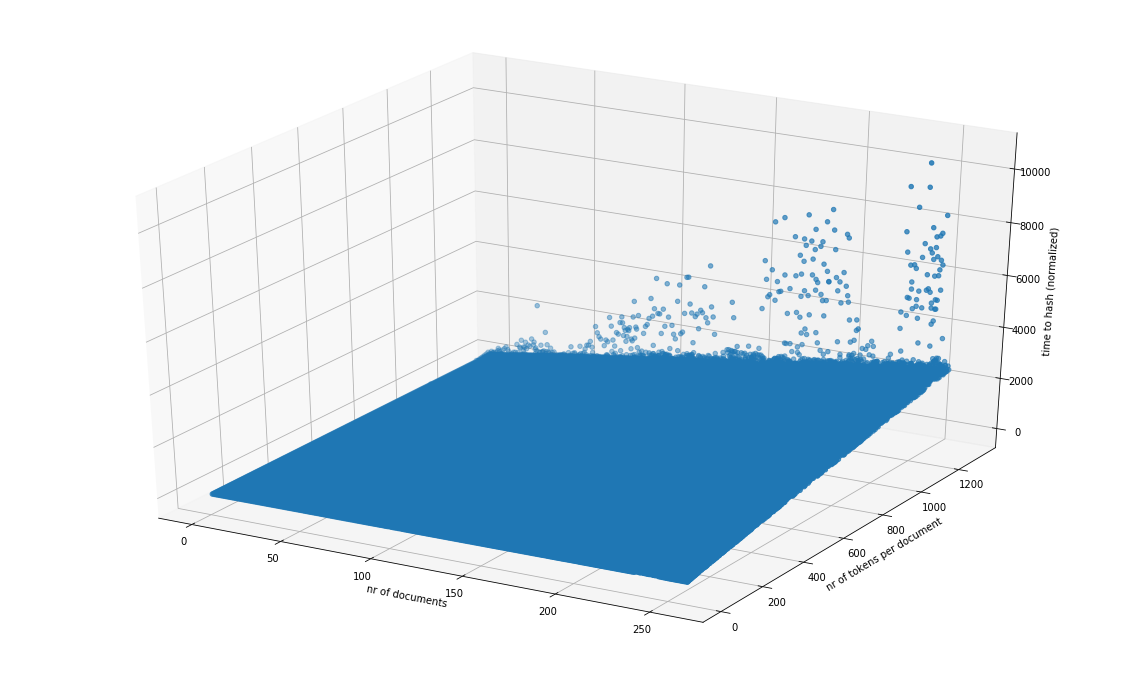

In [38]:
ax.scatter(xs, ys, zs)

ax.set_xlabel('nr of documents')
ax.set_ylabel('nr of tokens per document')
ax.set_zlabel('time to hash (normalized)')

plt.show()

##### plotting all three together

In [10]:
file_name = '0_d_tokens_documents.npy'
if os.path.isfile(file_name):
    zero = np.load(file_name)

In [9]:
file_name = '1_d_tokens_documents.npy'
if os.path.isfile(file_name):
    um = np.load(file_name)

In [ ]:
file_name = '2_d_tokens_documents.npy'
if os.path.isfile(file_name):
    dois = np.load(file_name)

In [31]:
from mpl_toolkits.mplot3d import Axes3D

In [32]:
xs = np.array(list(range(iterations))*iterations)  # nr of docs

In [33]:
y = []
for i in range(corpus_size, max_corpus_size, step):
    y += [i]*iterations
ys = np.array(y) # nr of tokens in each document

In [ ]:
z0 = zero / zero[0]

In [34]:
z1 = um / zero[0]

In [35]:
z2 = dois / zero[0]

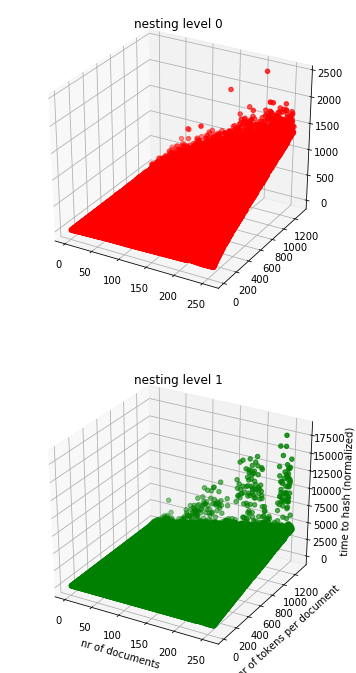

In [38]:
fig = plt.figure(figsize=plt.figaspect(3))
ax = fig.add_subplot(3, 1, 1, projection='3d')
ax.scatter(xs, ys, z0, c='r')
plt.title('nesting level 0')

ax = fig.add_subplot(3, 1, 2, projection='3d')
ax.scatter(xs, ys, z1, c='g')
plt.title('nesting level 1')

ax = fig.add_subplot(3, 1, 3, projection='3d')
ax.scatter(xs, ys, z2, c='b')
plt.title('nesting level 2')

ax.set_xlabel('nr of documents')
ax.set_ylabel('nr of tokens per document')
ax.set_zlabel('time to hash (normalized)')

plt.show()

# paper benchmark

in this benchmark we'll be using the Brazilian Portuguese and English dictionaries, for a corpus of moderate size.

In [5]:
with open('brazilian.txt', 'r') as f:
    portuguese = f.read().split()
english = words.words()

In [6]:
document = english + portuguese
corpus_length = len(document)
corpus_length

548577

In [7]:
corpus_size = 10
step = 100
iterations = 74
max_corpus_size = corpus_size + step*iterations
loops = 3
iterations_time = np.zeros((loops, iterations))

In [ ]:
%%time
i = 0
for size in range(corpus_size, max_corpus_size, step):
    corpus = []
    doc_length = size
    for doc in range(size):
        begin = doc*doc_length
        end = (1 + doc)*doc_length
        corpus.append(document[begin:end])
    for loop in range(loops):
        startt = timer()
        a = ch.CorpusHash(corpus, corpus_path)
        endt = timer()
        iterations_time[loop, i] = endt - startt
        shutil.rmtree(corpus_path)
    print(i)
    i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


saving data to disk:

In [8]:
file_name = 'paper-iterations-time.npy'
if os.path.isfile(file_name):
    iterations_time = np.load(file_name)
else:
    np.save(file_name, iterations_time)

plotting:

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

In [10]:
xs = np.arange(1, iterations+1)
ys = np.arange(corpus_size, max_corpus_size, step)
zs = np.average(iterations_time, axis=0)
normalized_zs = np.divide(zs, zs[0])

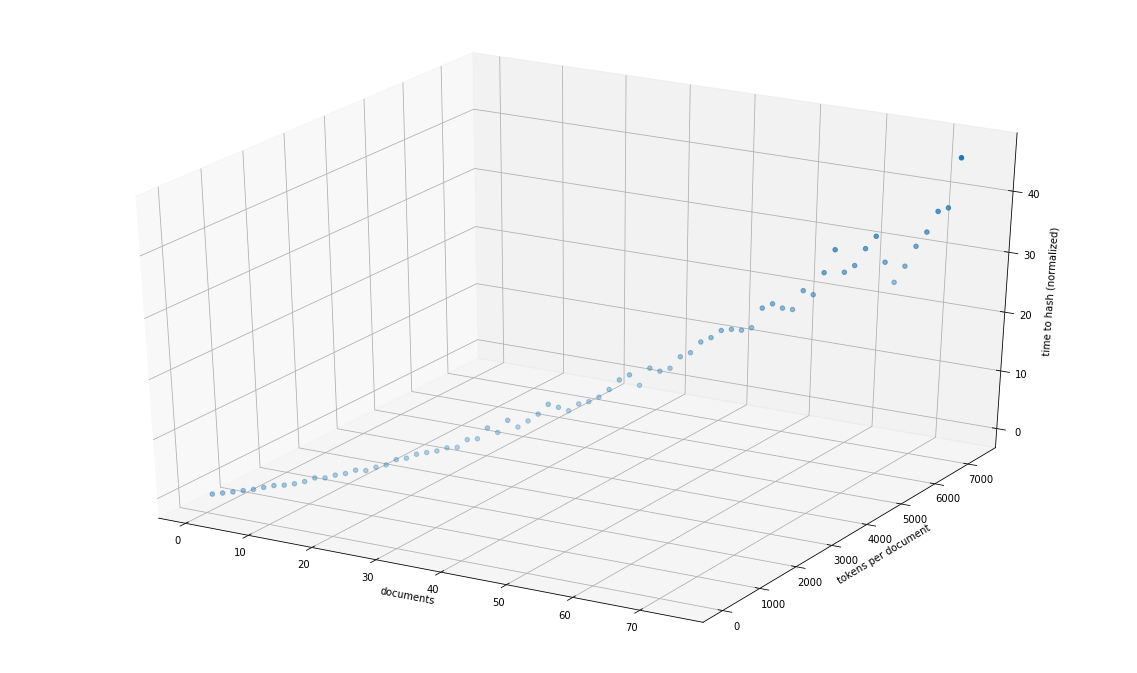

In [11]:
ax.scatter(xs, ys, zs)

ax.set_xlabel('documents')
ax.set_ylabel('tokens per document')
ax.set_zlabel('time to hash (normalized)')

plt.show()

In [12]:
z = np.polyfit(ys*xs, normalized_zs, 1)
p = np.poly1d(z)
print(p)

 
0.01821 x + 172.5


In [13]:
from PIL import Image
from io import BytesIO

saving plot as .tiff, for the paper:

In [15]:
fig = plt.figure(figsize=(20, 12), dpi=300)

xp = np.linspace(0, 600000, iterations, )  # creating evenly-spaced points to evaluate polynomial
plt.plot(xs*ys, normalized_zs, '.', xp, p(xp), 'r-')
plt.ylabel('time', fontsize=22)
plt.xlabel('corpus size (documents $\cdot$ words)', fontsize=22)
plt.text(300000, 3000, r'$y(x) = 0.01821 x + 172.5$', fontsize=20, color='r')
#plt.title('time to hash corpus')
plt.tick_params(axis='both', which='major', labelsize=20)


png1 = BytesIO()
fig.savefig(png1, format='png')

# (2) load this image into PIL
png2 = Image.open(png1)

# (3) save as TIFF
png2.save('complexity.tiff')
png1.close()

### benchmarking different nesting levels

In [19]:
document2 = []
for ix, word in enumerate(document):
    if ix % 2:
        document2.append([word])
    else:
        document2.append(word)

In [20]:
document3 = []
for ix, word in enumerate(document):
    if ix % 3 == 0:
        document3.append(word)
    elif ix % 3 == 2:
        document3.append([word])
    else:
        document3.append([[word]])

In [21]:
docs = [document, document2, document3]

In [35]:
corpus_length = len(document)
corpus_size = 10
step = 10000
iterations = 54
max_corpus_size = corpus_size + step*iterations
iterations_time = np.zeros((3, iterations))

In [36]:
max_corpus_size

540010

In [ ]:
%%time
i = 0
for size in range(corpus_size, max_corpus_size, step):
    for ix, doc in enumerate(docs):
        corpus = [doc[:size]]
        startt = timer()
        a = ch.CorpusHash(corpus, corpus_path)
        endt = timer()
        iterations_time[ix, i] = endt - startt
        shutil.rmtree(corpus_path)
    print(i)
    i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
CPU times: user 54min 19s, sys: 1min 30s, total: 55min 50s
Wall time: 55min 52s


In [7]:
file_name = 'nest-iterations-time.npy'
if os.path.isfile(file_name):
    iterations_time = np.load(file_name)
else:
    np.save(file_name, iterations_time)

In [8]:
iterations_time

array([[  3.12623597e-03,   1.33740706e+00,   1.50936674e+00,
          2.86173432e+00,   3.30142506e+00,   3.45451128e+00,
          4.21609150e+00,   4.71066009e+00,   5.81472738e+00,
          6.23533407e+00,   6.73713815e+00,   6.78698021e+00,
          7.78594358e+00,   7.89036434e+00,   9.64505456e+00,
          9.11839202e+00,   1.04714174e+01,   1.28669349e+01,
          1.18380810e+01,   1.23403305e+01,   1.32558810e+01,
          1.51693375e+01,   1.61763231e+01,   1.76498599e+01,
          1.64532349e+01,   1.65190210e+01,   1.66165349e+01,
          1.74722686e+01,   1.95066391e+01,   2.28594481e+01,
          1.82437525e+01,   2.10114818e+01,   2.32354548e+01,
          2.50620217e+01,   2.07973008e+01,   1.86729906e+01,
          2.08090244e+01,   2.17924555e+01,   2.57192630e+01,
          2.74621414e+01,   3.17745541e+01,   3.12979645e+01,
          3.37601603e+01,   3.18626763e+01,   3.48343388e+01,
          3.38201152e+01,   3.56749325e+01,   3.44450390e+01,
        

In [10]:
to_2_1 = np.divide(iterations_time[1], iterations_time[0])

In [15]:
print(to_2_1, np.mean(to_2_1), np.std(to_2_1))

[ 0.96179432  1.02468447  0.88188383  0.89481839  0.95355681  1.01866775
  1.09107566  1.02130826  0.96667499  1.0380661   1.06002084  1.1635246
  1.21769336  1.08822174  1.29278408  1.19839892  1.32558566  0.96899097
  1.07017152  1.08703821  1.11321893  0.97036283  1.02431455  0.96312432
  1.16750865  1.00923264  1.21461658  1.14009618  1.08474218  0.98445305
  1.39808457  0.98602717  1.04654423  1.08501746  1.42534253  1.2094244
  1.1018248   1.0623815   1.21493858  0.95000787  1.22881605  1.12035588
  1.05330482  1.28265028  1.08663799  1.20784689  1.00387899  1.10797881
  1.26650343  1.09601471  0.94406604  1.02932686  1.11362132  1.42547556] 1.10079076204 0.128034578525


In [17]:
to_3_1 = np.divide(iterations_time[2], iterations_time[0])

In [18]:
print(to_3_1, np.mean(to_3_1), np.std(to_3_1))

[ 1.00095931  1.20195705  0.98607781  0.99159099  1.05091505  1.35718105
  1.08871321  1.42678657  1.24248103  1.3608414   1.13392988  1.32932539
  1.32188054  1.24764579  1.16413874  1.32334005  1.37485013  1.02600536
  1.20490262  1.1079802   1.19814253  1.16886146  1.11561393  1.04333185
  1.24854193  1.14807702  1.29651765  1.21301115  1.35678711  1.07636859
  1.18410623  1.15608739  1.16126426  1.06380001  1.19156246  1.310562
  1.21161725  1.1459167   1.19836047  1.15388347  1.30587925  1.17180854
  1.24341757  1.28204345  1.1848312   1.1463275   1.14400805  1.11689908
  1.40922181  1.23416399  0.9875933   1.20822665  0.96685021  1.58431604] 1.19573152315 0.12494634549


In [20]:
to_3_2 = np.divide(iterations_time[2], iterations_time[1])

In [21]:
print(to_3_2, np.mean(to_3_2), np.std(to_3_2))

[ 1.04072075  1.17300211  1.11814932  1.10814775  1.10210009  1.33230982
  0.99783475  1.39701853  1.28531414  1.31093906  1.06972414  1.14249874
  1.0855611   1.1464996   0.9004897   1.10425671  1.0371643   1.05883893
  1.12589674  1.01926518  1.07628652  1.20456125  1.08913218  1.08327848
  1.069407    1.1375742   1.06742957  1.06395511  1.25079225  1.09336711
  0.84694893  1.17247011  1.10961795  0.98044506  0.83598324  1.08362457
  1.09964601  1.07863013  0.98635477  1.21460411  1.06271337  1.04592529
  1.18049167  0.9995269   1.09036423  0.9490669   1.1395876   1.00805094
  1.11268693  1.12604692  1.04610616  1.1738027   0.86820375  1.11142982] 1.09284894791 0.108188885768
